## **Proyecto 1:**  Clasificación de datos aplicados.

### **Librerias y lectura de los datasets.**


In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df1 = pd.read_csv('diabetes.csv')
df2 = pd.read_csv('ibm_employee_attrition.csv')

### **Exploración y preprocesamiento de datasets.**

### *Diabetes.*

##### Información general.

In [2]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [19]:
print(df1.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

##### Valores unicos.

In [8]:
print("Cantidad de valores unicos.")
print(df1.nunique())

Cantidad de valores unicos.
Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64


##### Analisis de distribución de datos.

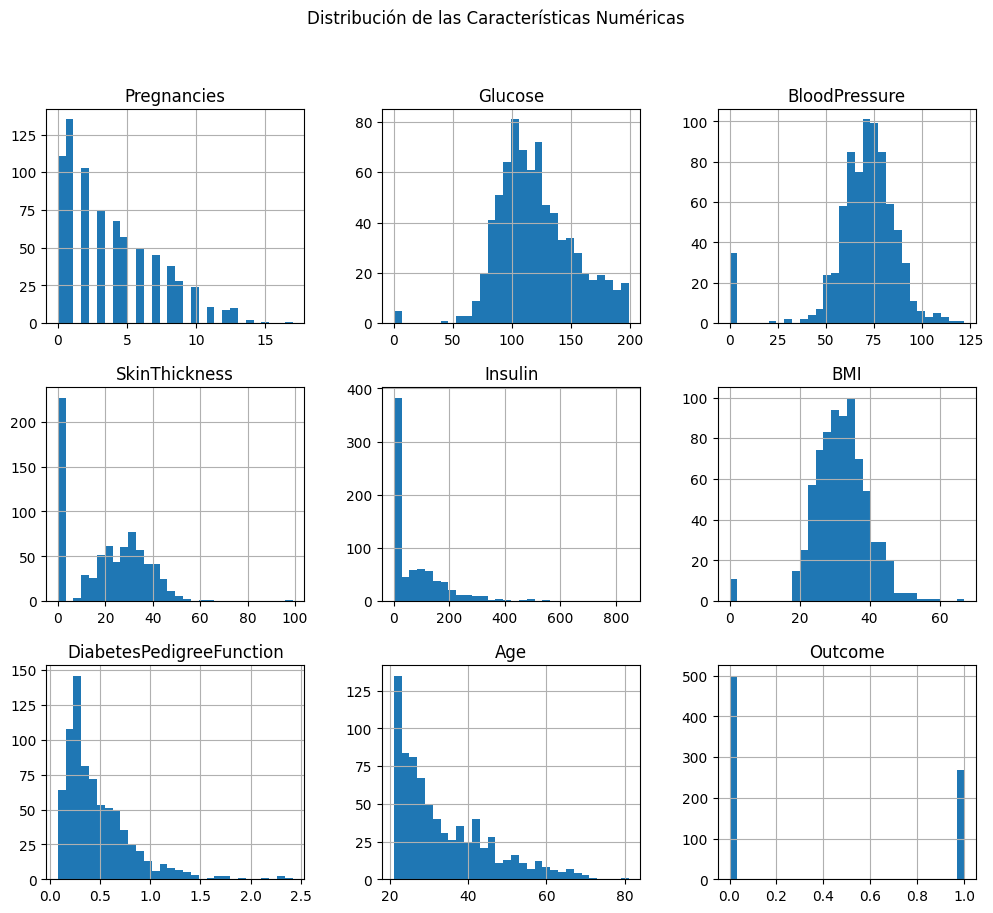

In [9]:
df1.hist(bins=30, figsize=(12, 10))
plt.suptitle('Distribución de las Características Numéricas')
plt.show()

In [10]:
# Ver cuántos ceros hay en las columnas que no deberían tener ceros
df1[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].apply(lambda x: (x == 0).sum())

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [11]:
# Se reemplazan los 0s con la mediana.
df1['SkinThickness'] = df1['SkinThickness'].replace(0, df1['SkinThickness'].median())
df1['Insulin'] = df1['Insulin'].replace(0, df1['Insulin'].median())

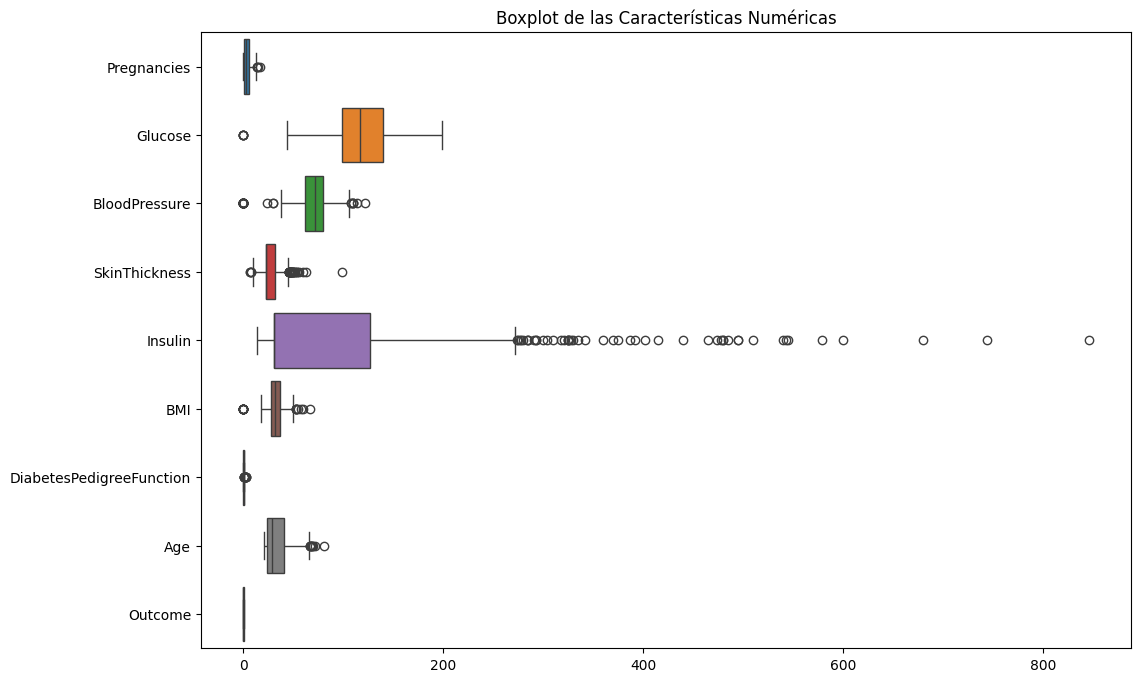

In [12]:
# Boxplot para identificar posibles valores atípicos
plt.figure(figsize=(12, 8))
sns.boxplot(data=df1, orient='h')
plt.title('Boxplot de las Características Numéricas')
plt.show()

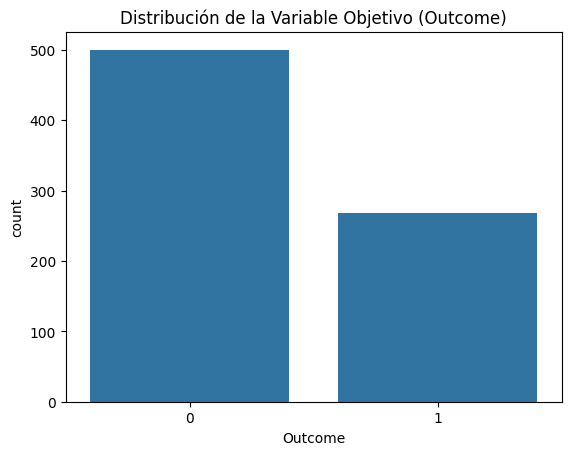

In [13]:
sns.countplot(x='Outcome', data=df1)
plt.title('Distribución de la Variable Objetivo (Outcome)')
plt.show()
#Conteo para ver el numero de pacientes con y sin diabetes.

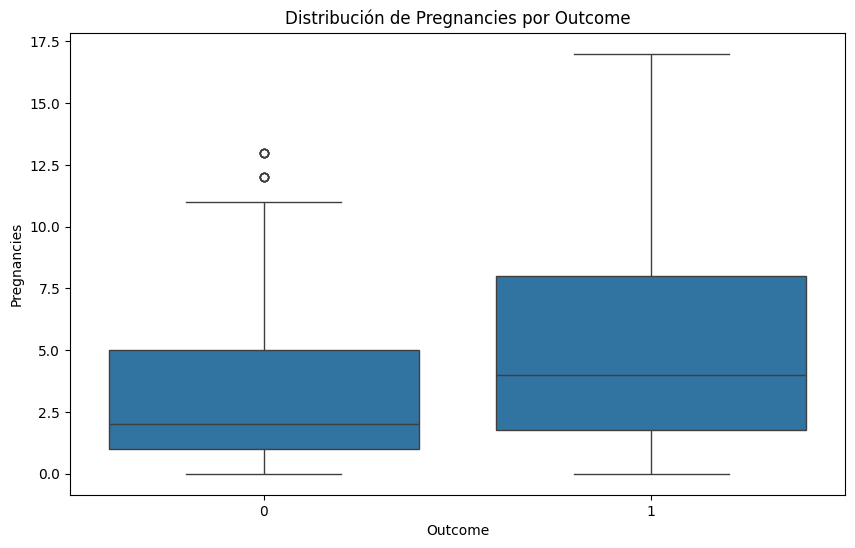

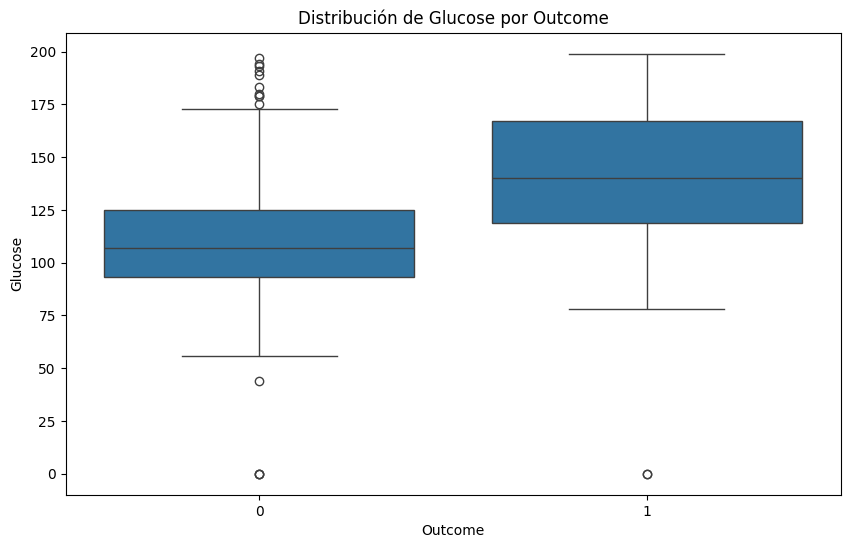

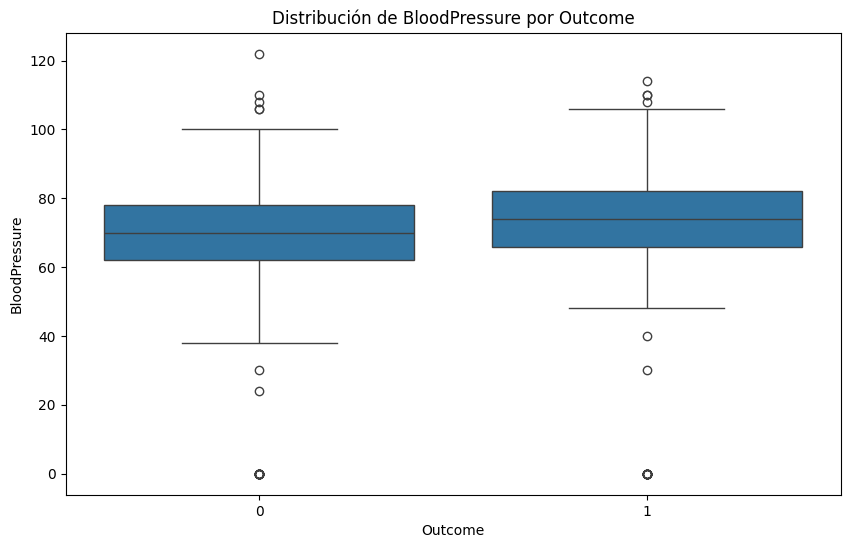

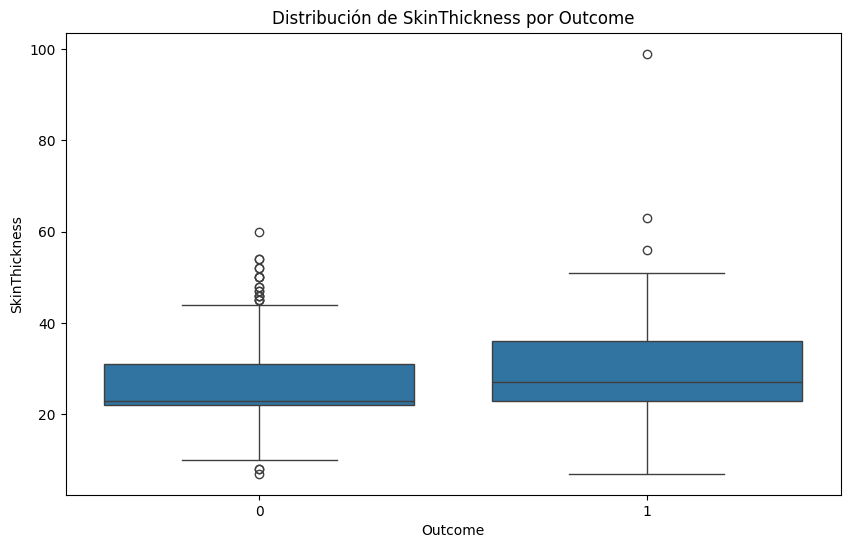

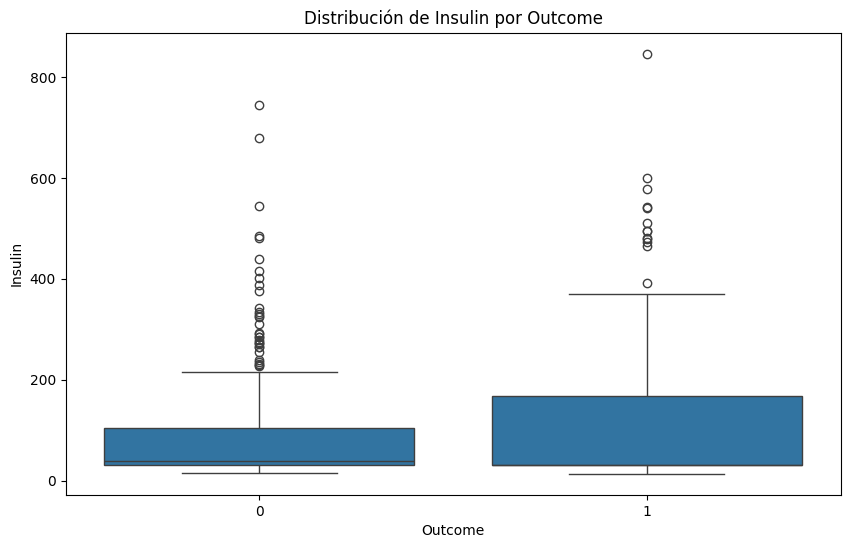

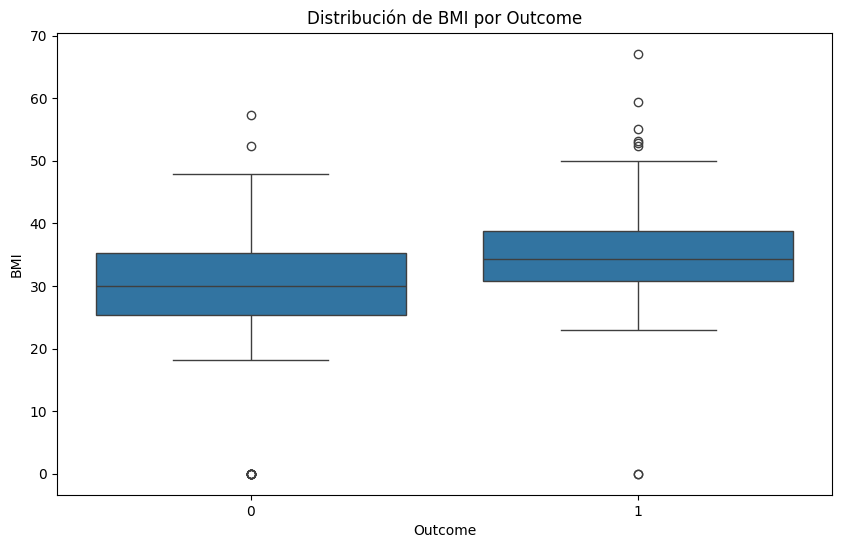

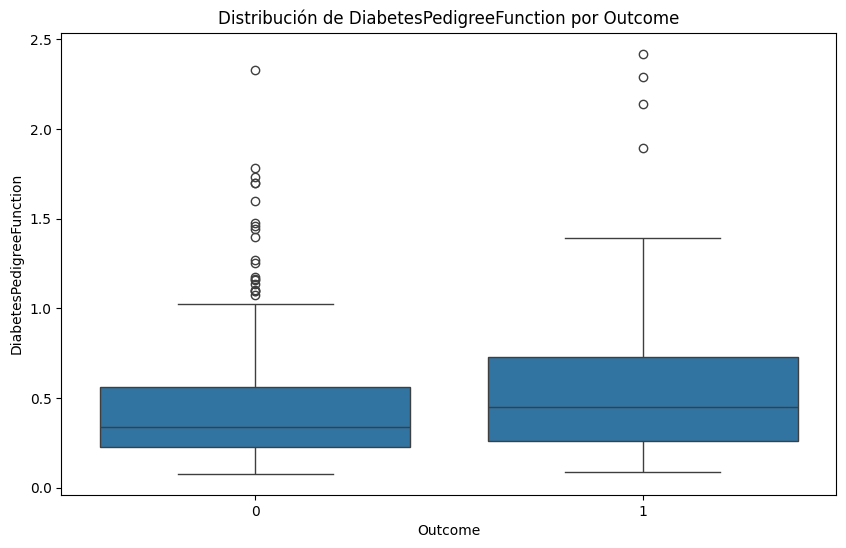

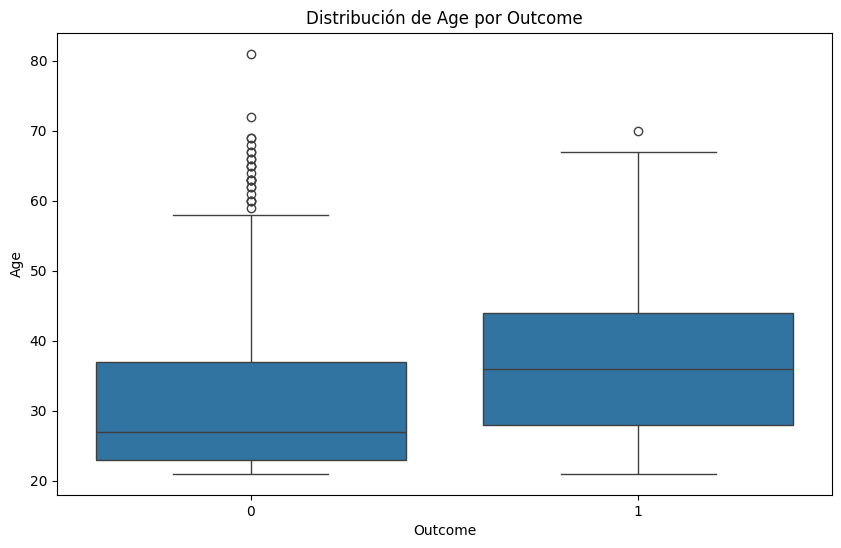

In [14]:
for column in df1.columns[:-1]:  
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Outcome', y=column, data=df1)
    plt.title(f'Distribución de {column} por Outcome')
    plt.show()
    
#Para comparar la distribución de características entre pacientes con y sin diabetes.

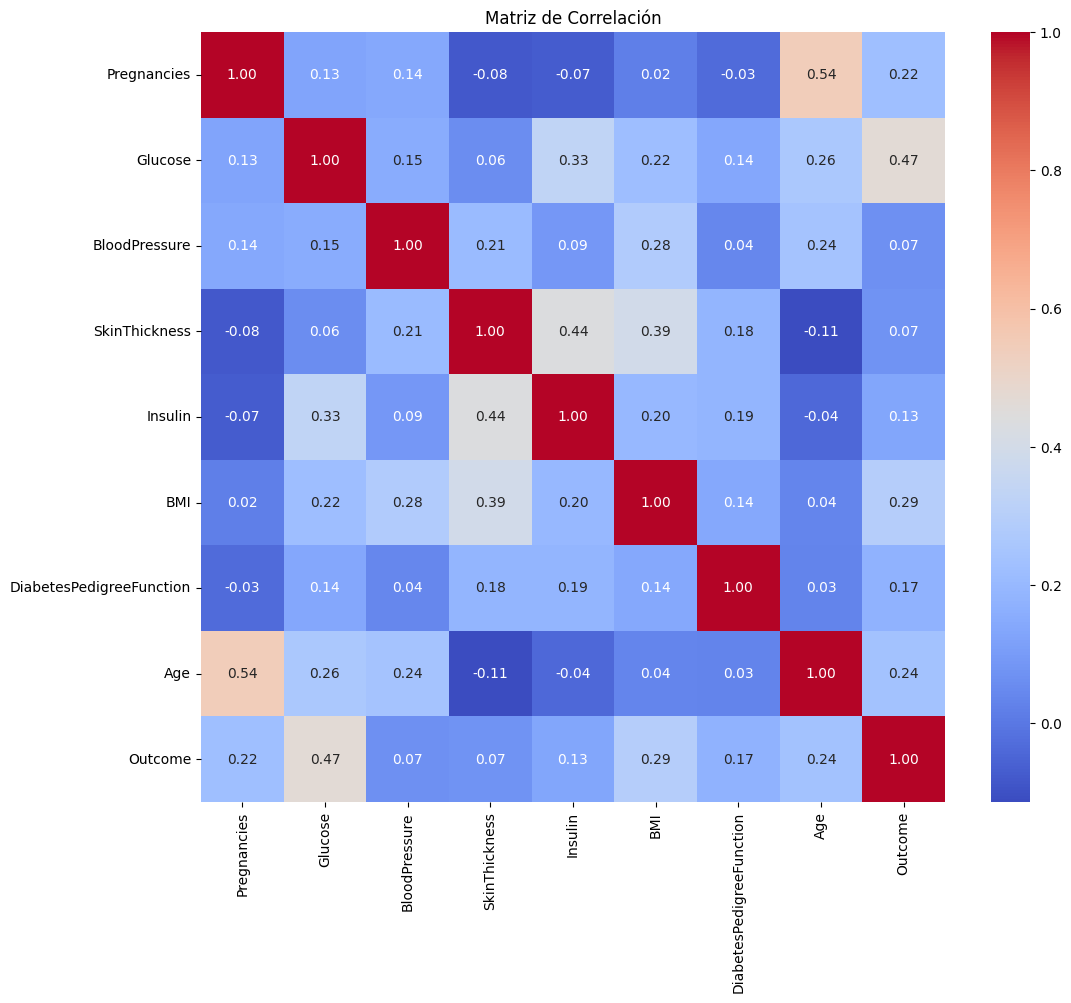

In [6]:
plt.figure(figsize=(12, 10))
correlation_matrix = df1.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()
#Para ver como se relaciona cada caracteristica con el outcome.